<a href="https://colab.research.google.com/github/Livy-Li/DynamicProgramming/blob/main/Stochastic_Inventory_Management_using_MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Summary

Inventory optimization models can be divided into two categories: deterministic and stochastic. Variable states are uniquely determined by the parameters in deterministic model; while stochastic models takes demand and/or system parameter uncertainties into account. The goal of stochastic inventory management is to determine the optimal timing of making replenishment orders and the order quantities, while taking demand and/or system parameter uncertainties into account. 

In this inventory management project, the goal is to optimize an inventory system by finding an optimal (s,S) policy. Under an (s,S) policy, the system will automatically send orders to supplier when the inventory level reaches or falls below the safety stock, s, and such order will fulfill the inventory back to level S. 

The given inventory problem is formulated as a Markov Decision Process(MDP) and solved using two different methods: Policy Iteration Algorithm and Q-Learning Algorithm. For computation purpose, the unit time is set to be 2 weeks, which is based on the 2-week material lead time. The MDP and algorithm are described and explained in detail in the notebook content. 



**Policy Iteration requires less iterations to converge to a solution and is much faster than Q-learning in this analysis. The safety stock level, s, recommended by Policy Iteration and Q-Learning are 33 and 12, respectively.**
The results and comparisons between two method are shown visually at the end of the notebook. It is clear that Q-learning is more computationally expensive than Policy Iteration due to the nature of the algorithm. Thus, to account for possible future demand and/or inventory capacity increase, it is better to use Policy Iteration. **Therefore, we recommend using the Policy Iteration algorithm in this inventory management project.**






#B. MDP Formulation

We have tried two different MDP formulations that had made sense to us.

The first formulation (B.1) is more closely aligned with the project description. However, the matrices generated were too large, they had to be stored in the form of sparse matrices, and we could not solve it using the algorithms in sections C.

The second formulation (B.2) is a simplified version, based on the assumption that if there is order in transit for the current period, no action would be taken. Because it is simplified, the matrices generated had smaller sizes, and we are able to solve them.

We present both formulation in section B to show our the thought process, but **section C,D,E are all based on formulation B.2.**

##B.1 MDP Formulation with Unit Time = 1 Week

Because of the two-week lead time, if the unit time is set to 1 week, there are 3 variables needed in the formulation of the question. They are: inventory on hand, inventory in transit, and inventory to be ordered. 

**Inventory on hand** is defined as the inventory we have at the beginning of the week, after receiving shipment if there is any shipment for that period. 

**Inventory in transit** is the inventory that has been ordered last week, and it will not arrive until the start of the next period. Because we do not have these inventory, we can neither sell them in the current period nor pay for its holding cost, therefore it does not come into play for the reward matrix, only in the transitonal matrix as we will see coming up.

**Inventory to be ordered** is the inventory to be ordered at the beginning of the week, it will not arrive for another two weeks.

For a problem to be in the same form as MDP, there need to be 5 basic components, namely **S** (a finite set of states), **A** (a finite set of actions), **R** (reward function), **P** (state transition probability matrix), and **gamma** (discount factor).

The **State S** in this set up has 2 components, the inventory on hand and the inventory in transit. It can be represented by a **tuple (inventory on hand, inventory in transit)**. For example (2,5) means that there are 2 inventory on hand and 5 inventory in transit. Because the maximum inventory is 500, inventory on hand can be any integer from 0 to 500, inventory in transit can also be any integer from 0 to 500. Therefore, there are 501*501 = 251001 states.

The **Action A** in this question has 1 component, which is the inventory to be ordered. Similarly it can be any integer from 0 to 500, there are 501 actions.

The **Reward R** in this question is defined as 

Revenue (inventory on hand, expected demand) - Ordering cost (inventory to be ordered) - Holding cost (inventory on hand) - stockout penalty (inventory on hand, expected demand). 

Both revenue and stockout penalty depends on expected demand. 

The revenue for each state-action combination can be calculated using the revenue function defined, and the result can be used to construct a revenue matrix. 

The shape if the revenue matrix is （S，A）, which in this case is (251001,501).

The **state transition probability matrix P** is best explained by examples. 

If the state for the current period is (0,4) and the action is 5, meaning that we currently have 0 inventory on hand, 4 inventory in transit, and 5 inventory to be ordered. Then next period, we will have 100% chance of reaching the state (4,5), because we have 100% chance of selling nothing (we have nothing to sell), the 4 inventory in transit for the current period becomes 4 inventory on hand next period, and the 5 inventory ordered this period becomes 5 inventory in transit next period.

If the state for the current period is (3,8) and the action is 4, meaning that we currently have 3 inventory on hand, 8 inventory in transit, and 4 inventory to be ordered. Then next period, we will have 8/11 chance of reaching state (8,3), 1/11 chance of reaching state (9,3), 1/11 chance of reaching state (10,3), 1/11 chance of reaching state (11,3). This is because we have 8/11 chance of selling all 3 inventory on hand (if demand is 3, 4, 5,...10, each with 1/11 probability), 1/11 chance of selling 2 inventory on hand (if demand is 2), 1/11 chance of selling 1 inventory on hand (if demand is 1) and 1/11 chance of selling nothing (if demand is 1). No matter how much we sell, the state for next period sums up the remaining inventory on hand and the 8 inventory in transit, which gives the inventory on hand for next period, the inventory in transit next period would be the action of this period, which is 3 for all of them.

Using this logic, we can construct the state transition probability matrix P for every action, each of the action has a state*state grid, but most of the grid would be filled with zeros. The matrix P will have the dimension of (A, S, S)， in this set up it is (501, 251001, 251001)

This transition matricies are very large, and mostly empty, therefore it is saved in the form of a list of sparse matrix, every element of the list is a possible action. Even though employing this technical did allow us to develop the transition matrix, it has proven later to be too large to run in the algorithms to solve them.

The **discount factor gamma** is not given in the project description, for the purpose of this project, we will assume that gamma is 0.95

In [1]:
#import necessary libraries
import numpy as np
from scipy.sparse import csr_matrix, dok_matrix, coo_matrix
from collections import namedtuple

In [2]:
# define variables and states

max_stock = 500  # 500
max_demand = 10  # 10

inventory_on_hand = np.arange(max_stock + 1)
inventory_in_transit = np.arange(max_stock + 1)
inventory_to_order = np.arange(max_stock + 1)

State = namedtuple('State', 'inventory_on_hand inventory_in_transit')

def states(possible_inventory_on_hand, possible_inventory_in_transit):
  for i in possible_inventory_on_hand:
    for j in possible_inventory_in_transit:
      yield State(i, j)

def state_index(stock_on_hand, stock_in_transit):
  return stock_on_hand*(max_stock+1) + stock_in_transit

In [3]:
# define demand probability and some constants
D_0 = 1/11
D_1 = 1/11
D_2 = 1/11
D_3 = 1/11
D_4 = 1/11
D_5 = 1/11
D_6 = 1/11
D_7 = 1/11
D_8 = 1/11
D_9 = 1/11
D_10 = 1/11

D_AVG = 0 * D_0 + 1 * D_1 + 2 * D_2 + 3 * D_3 + 4 * D_4 + 5 * D_5 + 6 * D_6 + 7 * D_7 + 8 * D_8 + 9 * D_9 + 10 * D_10

k = 100
c = 4
h = 2/52

In [4]:
#construct the demand matrix using the definition
reward_matrix1 = np.zeros((len(inventory_on_hand)*len(inventory_in_transit), len(inventory_to_order)))

for i in inventory_on_hand:
  for j in inventory_to_order:
      
    if i < 11:
      revenue = 10 * ((i*(i-1)*(1/2)+i*(11-i))/11)
      penalty = 15*(1/11)*((11-i)*(10-i))/2
    else:
      revenue = 10 * D_AVG
      penalty = 0
    
    if j > 0:
      ordering = k+c*j
    else:
      ordering = 0
    
    holding = h*i

    
    reward = revenue-ordering-holding-penalty

    reward_matrix1[i*(max_stock+1):i*(max_stock+1)+(max_stock+1),j] = reward

In [5]:
# reward matrix has the shape of S*A which is 251001*501
reward_matrix1

array([[  -75.        ,  -179.        ,  -183.        , ...,
        -2167.        , -2171.        , -2175.        ],
       [  -75.        ,  -179.        ,  -183.        , ...,
        -2167.        , -2171.        , -2175.        ],
       [  -75.        ,  -179.        ,  -183.        , ...,
        -2167.        , -2171.        , -2175.        ],
       ...,
       [   30.76923077,   -73.23076923,   -77.23076923, ...,
        -2061.23076923, -2065.23076923, -2069.23076923],
       [   30.76923077,   -73.23076923,   -77.23076923, ...,
        -2061.23076923, -2065.23076923, -2069.23076923],
       [   30.76923077,   -73.23076923,   -77.23076923, ...,
        -2061.23076923, -2065.23076923, -2069.23076923]])

In [6]:
#construct transitional matrix
#Note that if there is order in transit, the current period will have an action of 0

# transition_matrices = [csr_matrix(([], ([], [])), shape=((max_stock+1)*(max_stock+1), (max_stock+1)*(max_stock+1)))]*(max_stock+1)
transition_matrices = []

for a in inventory_to_order:
  transition_matrices.append(dok_matrix(((max_stock+1)*(max_stock+1), (max_stock+1)*(max_stock+1))))
  # assume we do not order more if there is an order in transit
  if a == 0:
    curr_inventory_in_transit = inventory_in_transit
  else:
    curr_inventory_in_transit = [0]
  for current_state in states(inventory_on_hand, curr_inventory_in_transit):
    for next_state in states(range(max(current_state.inventory_on_hand+current_state.inventory_in_transit-10, 0), min(current_state.inventory_on_hand+current_state.inventory_in_transit, max_stock)+1), [a]):
      if next_state.inventory_in_transit != a:
        continue

      stock_remaining = next_state.inventory_on_hand - current_state.inventory_in_transit
      stock_sold = current_state.inventory_on_hand - stock_remaining

      # if our inventory on hand + inventory that has just arrived is more than storage capacity discard extra inventory
      if next_state.inventory_on_hand == max_stock and current_state.inventory_on_hand + current_state.inventory_in_transit >= max_stock + max_demand:
        probability = 1
      elif stock_sold > max_demand:
        continue
      elif stock_remaining < 0:
        continue

      if stock_remaining == 0:
        probability = (max_demand - stock_sold + 1)*(1/11)
      else:
        probability = 1/11

      transition_matrices[a][state_index(current_state.inventory_on_hand, current_state.inventory_in_transit), state_index(next_state.inventory_on_hand, next_state.inventory_in_transit)] = probability

In [7]:
#The transition matrices have 500 sparse matrices, each with S*S dimension.
#which is 500*251001*251001

#transition_matrices

In [8]:
len(transition_matrices)

501

##B.2 MDP Formulation with Unit Time = 2 Week

Since the lead time is two weeks, and we can make the assumption that if there is order in transit for the current period, we do not order anyting for the current period. This assumption allow us to set the unit week to be 2 weeks, because even though the inventory is reviewed every week, we would only be taking action every 2 weeks.

Similar to the first setup, we need to define the S, A, R, P, and gamma.

For this formulation, **state S** is defined as inventory on hand for the current period, after receiving a shipment. Since the maximum inventory is 500, there are 501 possible state (all interger from 0 to 500)

**Action A** is defined as the inventory to be ordered this week, there are 501 possible actions (all interger from 0 to 500)

**Reward function R** is defined as 

Revenue (state, expected demand) - Ordering cost (action) - Holding cost (state) - stockout penalty (state, expected demand)

It should be noted that because the unit time is 2 weeks, all variables such as demand, holding cost are adjusted so they are on a bi-weekly base.

Both revenue and stockout penalty depends on expected demand.

The revenue for each state-action combination can be calculated using the revenue function defined, and the result can be used to construct a revenue matrix.

The shape if the revenue matrix is （S，A）, which in this case is (501,501).

**The state transition probability matrix P** is best explained by examples.

If current state is 0, and current action is 100, then there is a 100% chance that my next state is 100, because we have 100% chance of selling nothing (we have nothing to sell), the 100 inventory we order this week will become our inventory on hand (state) next week.

If current state is 2, and current action is 100, there is 1/121 chance that the next state is 102, meaning no consumption for the two weeks. There is a 2/121 chance that the next state is 101, meaning 1 consumption for the next two weeks. There is 118/121 chance that the next state is 100, meaning the consumption for the next two weeks is larger than or equal to 2 (it could be between 2 to 20). The demand probability distribution is adjusted to bi-weekly basis, so for example, the probability of no consumption for the next two weeks is 1/11*1/11 = 1/121.

Using this logic, we can construct the state transition probability matrix P for every action, each of the action has a state*state grid. The matrix P has the dimension of (A, S, S)， in this set up it is (501,501,501)

It is worth noting that, to ensure every row of the probability matrix sums up to 1, the assumption is that if the next state is greater than 500, then the excess inventory are discarded. In otherwords, the possibilities of state>500 are all added to the possibility of state=500, because that is the max inventory level.

The **discount factor gamma** is not given in the project description, for the purpose of this project, we will assume that gamma is 0.95

In [9]:
#import necessary libraries
import numpy as np

In [10]:
#adjust demand probability function to be bi-weekly based
#for every two weeks
#Pr(D=0)=1/11 * 1/11 = 1/121
#Pr(D=1)=1/11 * 1/11 + 1/11 * 1/11 = 2/121 
#Calculate demand from D=0 to D=20

D = np.zeros(21)
for i in range(11):
  D[i] = 1/11*1/11*(i+1)
  D[20-i] = D[i]
D[11] = 1/11*1/11*10
D_avg = 0
for i in range(1,21):
  D_avg = D_avg + i*D[i]

In [11]:
#define states, actions and constants
states = np.arange(501)
actions = np.arange(501)
k = 100
c = 4
h = 2/52*2
discount = 0.95

In [12]:
# construct reward matrix
# size of the reward matrix is S*A (501*501)

reward_matrix = np.zeros((len(states), len(actions)))
for state in states:
  for action in actions:
    revenue = 0
    penalty = 0
    ordering = 0
    over_ordering_penalty = 0
    potential_total = state + action

    if state < 21:
      for i in range(state+1):
        revenue = revenue + 10*D[i]
      for j in range(state+1,21):
        penalty = penalty + 15*D[j]
    else:
      revenue = 10*D_avg

    if potential_total > 500:
      over_ordering_penalty = 999999999
    
    if action > 0:
      ordering = k+c*action
    
    holding = state*h
    
    reward = revenue-ordering-holding-penalty-over_ordering_penalty
    reward_matrix[state,action] = reward

In [13]:
# construct transition matrix
# size of the transition matrix is A*S*S (501*501*501)
transition_matrix = np.zeros((501,501,501)) # action, current state, future, orders cannot be changed

# default table: action = 0
for i in range(20):
  transition_matrix[0][i][0] = 1
  for j in range(i):
    transition_matrix[0][i][i-j] = D[j]
    transition_matrix[0][i][0] = transition_matrix[0][i][0] - D[j]

for i in range(20,501):
  for j in range(21):
    transition_matrix[0][i][i+j-20] = D[j]

for i in range(1,501):
  P_removed = np.delete(transition_matrix[i-1],-1,axis=1)
  temp = np.append(np.zeros((501,1)),P_removed, axis = 1)
  transition_matrix[i] = temp
  for j in range(501):
    P_sum = transition_matrix[i][j].sum()
    if P_sum < 1:
      transition_matrix[i][j][-1] = transition_matrix[i][j][-1] + 1 - P_sum

#C. Methods

Mdptoolbox is used as the solver for this project, as explained before the matrices developped from B.1 is too large to be solved using the mdptoolbox, therefore for section C,D,E, they are all based on the matrices developped from B.2

In [14]:
#install mdptoolbox
!pip install pymdptoolbox

  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-cp37-none-any.whl size=25657 sha256=32ffef7cd8e87e83c834b1f3f05f9713c5ba9d01f4bcb951b12965ab4a255c47
  Stored in directory: /root/.cache/pip/wheels/87/a9/a8/40c4e252c02e590737265742425cdd0365fafcc162441a9527
Successfully built pymdptoolbox


In [15]:
#import mdptoolbox
import mdptoolbox

##C.1 Policy Iteration

Policy iteration is one of the algorithms used to solve the Markov decision process. For a question to be formed into the Markov decision process, it has defined state space and action space. For a given state, there are often more than one choice of action that can be taken. A unique combination of actions taken in all different states is defined as a policy. The total number of policies depends on the number of states and number of actions of the question, but often there are a large quantity of possible policies, and trying to determine the best policy is difficult. Policy is a mapping of an action to every possible state in the system. An optimal policy is that policy which maximizes the long term reward.

In order to compare between different policies, value functions can be used to evaluate different policies. The value function of a given state depends on the reward of the current state, and the sum of reward of possible future states given the probability of those future states. The policy that has the maximum value from the value function is the optimal policy for the given state. Ultimately, the goal of policy iteration is to find the best policy to maximize the value function predefined based on the context of the question. 

The process of policy iteration includes first randomly initializing the policy, meaning initializing actions randomly at every state of the system. Then get action for every state in the policy and evaluate the value function using the Bellman equation. Then for every state, get the best action from the value function, improving on that policy and updating it. If the updated policy is a new policy, then the process would have to be iterated again, but if the improved policy is the same as the old policy, it means the current policy is the best policy.

We are using mdptoolbox to implement the  algorithm, which will be explained in more detail in section D. It is worth noting that policy iteration can be evaluated in two different ways, either by solving a set of linear equations, or solving them iteratively. The method employed here is the “matrix”, which is to solve linear equations. It is not necessary to input an initialization of policy in the program, because it is optional and the program will make initialization if not provided with one.

Policy iteration converges faster than Q-learning, indicating it takes fewer iterations to reach the result. Policy iteration is capable of finding not just a result that is close to the optimal result, it can find the actual optimal result with no minor deviation.

The output of the algorithm is the best policy determined by the policy iteration algorithm. For each state, there is a corresponding action that when grouped with other actions, will produce best results according to the reward function. In the context of the question, it means for every possible inventory on hand, there is an optimal number of inventory to be ordered according to the best policy.





In [16]:
pi_1000 = mdptoolbox.mdp.PolicyIteration(transition_matrix, reward_matrix, 0.95, max_iter=1000)
pi_1000.run()

In [17]:
pi_10000 = mdptoolbox.mdp.PolicyIteration(transition_matrix, reward_matrix, 0.95, max_iter=10000)
pi_10000.run()

##C.2 Q-Learning

For Q-learning, it works with states and rewards as inputs and actions as output. There is a table called Q-table created in between to record the value for each state-action combination. It attempts to construct an optimal policy by interacting with the environment and aims to find the optimal action for the current state. This model is not environment specific, instead, is a model free learning model and it can apply to any environment. There is no transition or reward function for the algorithm to estimate the dynamics. In Q-learning, the number of possible states and possible actions are finite. 

Q-learning is a value-based method and the values will be translated into a policy. The policy is updated according to the Q values, which indicates the quality of a particular action in a given state. It estimates the sum of future rewards and tries to approach the highest reward. We would like to maximize the reward and earn the highest revenue. It aims to assess the quality of a particular action to move to a state instead of calculating the possible value of the state that is being moved to. During the exploration phase, the errors and the variance might be large. However, the reward would be maximized once the agent explored enough. 

Bellman equation is the fundamental equation used in Q-learning. The equation indicates that the value of being in a particular state equals the maximum value of the reward function (from a state and an action) plus the discount factor times the value of the agent being in the previous state. The ultimate goal is to consider all the possible actions and choose the one that yields the maximum value.
The steps involved in Q-learning will be explained. First of all, the agent initializes in a state for the agent. An action should be chosen along with the state to receive a reward. Q-table will record the sets of state and set of actions. The table will be A*S format, where A is the number of actions and S is the number of states. Then the agent will select the action with the highest value in the Q-table. The available action in our case is to order or not make any order. The action will be performed and a new reward will be computed. A temporal difference will be calculated. At the end, the q-value will be updated with the highest value for the state and action pair until the current state is a terminal state. This process will be repeated until the state is terminal.

The matrix would be large due to the number of possible actions (order quantity) and possible states (inventory level) in our case so there would be lots of repetitive work in the process. The amount of memory required to save and update the table increases as the number of states increases. The amount of time to compute the state would also be noticeable with this amount of state and action. In a low-cost or fast-iterating environment, Q-learning is a good method to use since it learns the optimal policy directly.


In [18]:
ql_10000 = mdptoolbox.mdp.QLearning(transition_matrix, reward_matrix, 0.95, n_iter=10000)
ql_10000.run() 

In [19]:
ql_100000 = mdptoolbox.mdp.QLearning(transition_matrix, reward_matrix, 0.95, n_iter=100000)
ql_100000.run() 

#D. Explanation and Visualization of the solutions found

In [20]:
import matplotlib.pyplot as plt

##D.1 Policy Iteration

Using policy iteration, the best policy can be visualized below. The algorithm determines that if the state is larger than 33, it is best to not take any action. Meaning that if inventory on hand for the current period is more than 33, it is in the store owner's best interest to not put in new orders.

If the state is less than 33, it is best to purchase no more than 99 inventory. The larger the state, the less new orders of inventory should be. As the state becomes larger (from 0 to 33), the action becomes smaller (from 99 to 77).

It is worth noting that the result produced by policy iteration when max_iter = 1000, is exactly the same as the result produced when max_iter=10000. This means that the algorithm converged within 1000 iterations, therefore the two lines are indistinguishable from each other on the graph.


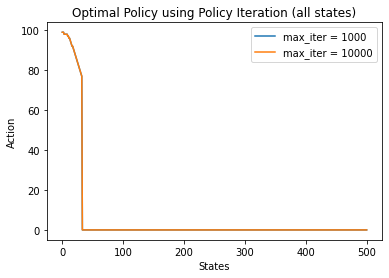

In [21]:
#plot the result for policy iteration for all states
pi_1000_result = pi_1000.policy
pi_10000_result = pi_10000.policy
plt.plot(pi_1000_result, label='max_iter = 1000')
plt.plot(pi_10000_result, label='max_iter = 10000')
plt.legend(loc="upper right")
plt.title('Optimal Policy using Policy Iteration (all states)')
plt.xlabel('States')
plt.ylabel('Action')
plt.show()

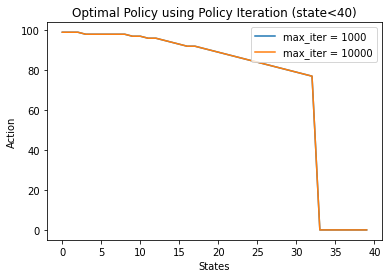

In [22]:
#plot the result for policy iteration for state<40, a more zoomed in graph
pi_1000_result_zoomin = pi_1000.policy[:40]
pi_10000_result_zoomin = pi_10000.policy[:40]
plt.plot(pi_1000_result_zoomin, label='max_iter = 1000')
plt.plot(pi_10000_result_zoomin, label='max_iter = 10000')
plt.legend(loc="upper right")
plt.title('Optimal Policy using Policy Iteration (state<40)')
plt.xlabel('States')
plt.ylabel('Action')
plt.show()

##D.2 Q-Learning

Using the q-learning method, the result can be visualized below. It should be noted that the Q-Learning algorithm has not converged after 100000 iterations. The result from 10000 iterations is very different from the result from 100000 iterations.

If the result is more optimal with more iterations, then the 100000 iteration result is what we should analyze. The algorithm determines that if the state is larger than 12, it is best to not take any action. Meaning that if inventory on hand for the current period is more than 12, it is in the store owner's best interest to not put in new orders.

If the state is less than 12, it is best to purchase no more than 140 inventory. However, the action jumps up and down without a clear pattern. It is most likely because the program has not converged yet.


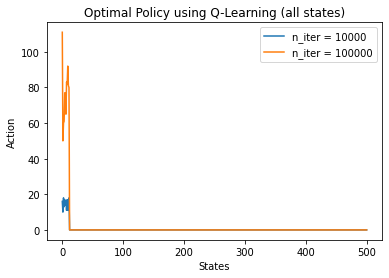

In [23]:
#plot the result for Q-Learning for all states
ql_10000_result = ql_10000.policy
ql_100000_result = ql_100000.policy
plt.plot(ql_10000_result, label='n_iter = 10000')
plt.plot(ql_100000_result, label='n_iter = 100000')
plt.legend(loc="upper right")
plt.title('Optimal Policy using Q-Learning (all states)')
plt.xlabel('States')
plt.ylabel('Action')
plt.show()

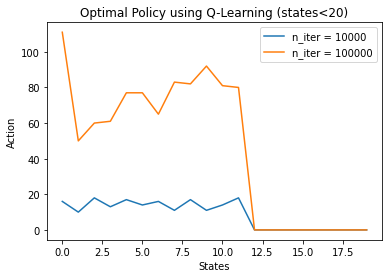

In [24]:
#plot the result for Q-Learning for state<20, a more zoomed in graph
ql_10000_result_zoomin = ql_10000.policy[:20]
ql_100000_result_zoomin = ql_100000.policy[:20]
plt.plot(ql_10000_result_zoomin, label='n_iter = 10000')
plt.plot(ql_100000_result_zoomin, label='n_iter = 100000')
plt.legend(loc="upper right")
plt.title('Optimal Policy using Q-Learning (states<20)')
plt.xlabel('States')
plt.ylabel('Action')
plt.show()

##D.3 Comparison Between Two Methods

Comparing the two methods, it is evident that the result from policy iteration is smoother than the result from q-learning. Policy iteration also converges faster than q-learning, which makes it more preferable than q-learning.

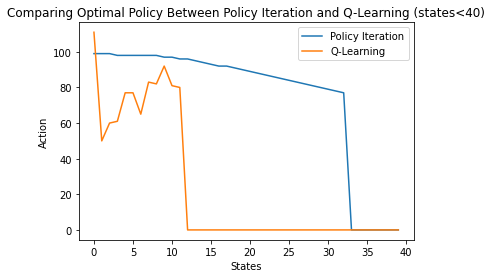

In [25]:
plt.plot(pi_10000_result[:40], label='Policy Iteration')
plt.plot(ql_100000_result[:40], label='Q-Learning')
plt.legend(loc="upper right")
plt.title('Comparing Optimal Policy Between Policy Iteration and Q-Learning (states<40)')
plt.xlabel('States')
plt.ylabel('Action')
plt.show()

#E. Lessons Learned

The (S,s) inventory model is setup and formulated using Markov Decision Process (MDP). Two approaches were performed, the first one being having the state setup as a matrix of inventory on hand and inventory on order with time period set to 1 week, the second one being the state setup as a matrix of inventory on hand only, but changing the time period to 2 weeks to accomodate the leadtime. However, due to overly-large sparse matrices and hardware and resource constraints, the first approach cannot be computed. The second approached was computed using both Policy-Iteration and Q-Learning algorithms. 

The Policy-Iteration algorithm performs better than the Q-Learning algorithm as the Q-Learning algorithm cannot converge even with 100K iterations. Both algorithms have suggested a low on-hand profile and low to medium ordering strategy. This matches our observation that the leadtime is relatively not too long and the weekly demand is low.

Overall, the Markov Decision Process approach was able to offer optimal policy solutions for each inventory state. It is a more flexible model compared to other industry models such as the EOQ, Newsboy and etc.